(<Figure size 360x360 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'train data'}>,
         <AxesSubplot:title={'center':'test data'}>,
         <AxesSubplot:title={'center':'output'}>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

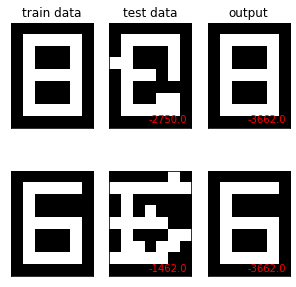

In [39]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, division

import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
import matplotlib.cm as cm


class HopfieldNetwork(object):
    threshold = 0

    def fit(self, train_list):
        """
        初期化: 学習データから重み行列を初期化
        """
        self.dim = len(train_list[0])

        self.W = np.zeros([self.dim, self.dim])
        # for _ in range(10):
        for i in data:
            self.W += np.outer(i, i.T)

        for i in range(self.dim):
            self.W[i][i] = 0     # 対角成分を0にする

    def predict(self, data, threshold=0, loop=10):
        """
        更新: 入力値のリストに対し、出力値のリストを返す
        """
        self.threshold = threshold
        return [self._predict(d, loop=loop) for d in data]

    def _predict(self, xr, loop=10):
        """
        個々の入力値に対し、ユニットの値が収束するまで =
        エネルギーが変化しなくなるまで更新を行う
        """
        e = self.energy(xr)
        for i in range(loop):
            xr = self.W.dot(xr) - self.threshold
            # xr の符号をとる
            xr = np.sign(xr)
            e_new = self.energy(xr)
            if e == e_new:
                return xr
            e = e_new
        return xr

    def energy(self, xr):
        """
        ユニットの状態からネットワークのエネルギーを計算
        """
        return -0.5 * xr.dot(self.W).dot(xr) # + np.sum(xr * self.threshold)

    def plot_weight(self):
        """
        重み行列をヒートマップとしてプロット
        """
        fig, ax = plt.subplots(figsize=(5, 3))
        heatmap = ax.pcolor(self.W, cmap=cm.coolwarm)
        cbar = plt.colorbar(heatmap)

        ax.set_xlim(0, self.dim)
        ax.set_ylim(0, self.dim)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        return fig, ax

    def plot_data(self, ax, data, with_energy=False):
        """
        data を画像化 (2次元化) して ax にプロット
        """
        # dim = int(np.sqrt(len(data)))
        # このサンプルで扱う画像は縦横 同じ長さのもののみ
        # assert dim * dim == len(data)

        img = (data.reshape(9, 7) + 1) / 2
        ax.imshow(img, cmap=cm.Greys_r, interpolation='nearest')
        if with_energy:
            e = np.round(self.energy(data), 1)
            ax.text(0.95, 0.05, e, color='r', ha='right',
                    transform=ax.transAxes)
        return ax


# ユーティリティ関数

def get_corrupted_input(input, corruption_level):
    """
    入力にノイズを付与
    """
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def plot(hn, data, test, predicted, figsize=(5, 7)):
    """
    元データ、テストデータ、推測値を描画
    """
    fig, axes = plt.subplots(len(data), 3, figsize=figsize)
    for i, axrow in enumerate(axes):
        if i == 0:
            axrow[0].set_title('train data')
            axrow[1].set_title('test data')
            axrow[2].set_title('output')
        hn.plot_data(axrow[0], data[i])
        hn.plot_data(axrow[1], test[i], with_energy=True)
        hn.plot_data(axrow[2], predicted[i], with_energy=True)

        for ax in axrow:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
    return fig, axes

arr = np.load('src/numbers2.npy')
two = arr[8]
nine = arr[6]
# data = data[-2:]
data = np.stack([two, nine])
data = [d * 2 - 1 for d in data]

# Hopfield Network インスタンスの作成 & 学習
hn = HopfieldNetwork()
hn.fit(data)

# 画像に 10% のノイズを付与し、テストデータとする
test = [get_corrupted_input(d, 0.1) for d in data]
# Hopfield Network からの出力
predicted = hn.predict(test)

plot(hn, data, test, predicted, figsize=(5, 5))

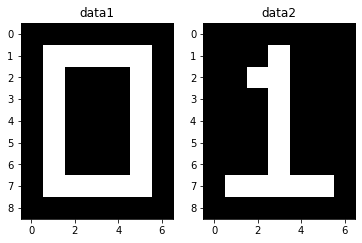

100%|██████████| 100/100 [00:00<00:00, 3845.16it/s]


(63,)


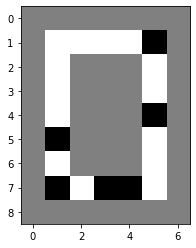

distance = 3.16
accuracy = 0.0


In [17]:
# -*- coding: utf-8 -*-
import argparse
import copy

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import *
from tqdm import tqdm


class Hopfield:
    def __init__(self, train_data):
        self.train_data = train_data[:, :2]
        self.train_num = 2
        self.width = 7
        self.height = 9
        self.noise = 0.2
        self.loop_update = 300
        self.loop_test = 100
        self.syn = False
        self.W = np.zeros((self.width*self.height, self.width*self.height))

        # トレーニングデータのプロット
        self.plot(self.train_data.T, 'train_data')

    # エネルギー計算の関数
    def energy(self, x):
        # V = -1/2 * ΣΣ w*x*x
        return -0.5*np.dot(x.T, np.dot(self.W, x))

    # 類似度（距離）計算
    def distance(self, x):
        # 対象データと訓練データの差を計算
        x = x.reshape(self.width * self.height, 1)
        dis = np.sum(np.abs(self.train_data - x), axis=0) / 2

        # 最小の距離とそのインデックスを取り出す
        sim = np.min(dis)
        simidx = np.argmin(dis)
        # print('train model = {0}, distance = {1}'.format(simidx, sim))
        return sim, simidx

    # テストデータの作成
    def test_make(self, test_idx):
        x_test = copy.deepcopy(self.train_data[:, test_idx])
        # 確率rateで符号を反転させる
        flip = choice([1, -1], self.width * self.height, p=[1 - self.noise, self.noise])
        x_test = x_test * flip

        return x_test

    # トレーニングデータによる学習
    def fit(self):
        self.W = np.dot(self.train_data, self.train_data.T)/self.train_num  # W = Σ x*x^T
        for i in range(self.width * self.height):
            self.W[i, i] = 0  # 対角成分0

        return self.W

    # テストデータを使って想起(非同期更新)
    def predict_asyn(self, test_data):
        for _ in range(self.loop_update):
            num = randint(self.width*self.height)
            test_data[num] = np.sign(np.dot(self.W[num], test_data))

        return test_data

    # 同期更新
    def predict_syn(self, test_data):
        e_old = float("inf")
        for _ in range(self.loop_update):
            # テストデータの更新とエネルギーの計算
            test_data = np.sign(np.dot(self.W, test_data))
            e_new = self.energy(test_data)

            # エネルギーが変化しなくなったら打ち切り
            if e_new == e_old:
                break

            e_old = e_new

        return test_data

    # 描画
    def plot(self, data, name='example'):
        for i in range(len(data)):
            train_graph = data[i].reshape(9, 7)
            plt.subplot(1, len(data), i + 1)
            plt.imshow(train_graph, cmap=cm.Greys_r, interpolation='nearest')
            plt.title(f'data{i+1}')

        plt.show()
        # plt.savefig('fig/{}.png'.format(name))

    def run(self, test_idx):
        dis = 0  # 正解と異なるマスの数
        acc = 0  # 正解率

        # 訓練データから重み行列の計算
        self.W = self.fit()

        for l in tqdm(range(self.loop_test)):
            # テストデータの作成
            test_data = self.test_make(test_idx)
            # self.plot(test_data.reshape(1, -1), 'test_{:04d}_data'.format(l))

            # テストデータからの想起
            # test_predict = self.predict_syn(test_data) if self.syn else self.predict_asyn(test_data)
            test_predict = self.predict_syn(test_data)
            # self.plot(test_data.reshape(1, -1), 'test_{:04d}_after'.format(l))
            
            # 正答率，距離の計算
            _dis, _ = self.distance(test_predict)
            dis += _dis
            if _dis == 0:
                acc += 1

            # print(_dis, acc)
        print(test_data.shape)
        flatten_predict = test_data.reshape(9, 7)
        plt.imshow(flatten_predict)
        plt.gray()
        plt.show()

        dis /= self.loop_test
        acc /= float(self.loop_test)
        print("distance = {0}".format(dis))
        print("accuracy = {0}".format(acc))


def main():
   

    

    # トレーニングデータ読み込み(6*25)
    train_data = np.load("src/numbers2.npy").astype(np.float32)
    train_data = train_data.T

    hop = Hopfield(train_data)
    test_idx = 0
    hop.run(test_idx)


if __name__ == '__main__':
    main()

In [45]:
from __future__ import unicode_literals, division
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2)
import matplotlib.cm as cm


# """ 重み行列Wを計算 """
# def fit(dim, data):
#     w = np.zeros([dim, dim])
#     # for _ in range(10):
#     for i in data:
#         w += np.outer(i, i.T)

#     for i in range(dim):
#         w[i][i] = 0     # 対角成分を0にする
#     return w

# """ 学習データにノイズを与え、テストデータを作成 """
# def noise(data, rate):
#     test_data = np.copy(data)
#     inv = np.random.binomial(n=1, p=rate, size=len(data))
#     for i, v in enumerate(data):
#         if inv[i]:
#             test_data[i] = -1 * v
#     return test_data

# ''' エネルギー関数E(x)を定義し、収束するまで繰り返す '''
# def energy(data, w):
#     return -0.5 * np.dot(w, np.dot(data, data.T))
    

# """ エネルギーが変化しなくなるまで更新を行う """
# def predict(test_data, w):
#     e_old = float("inf")
#     for _ in range(300):  # self.loop_updateは更新の上限値
#         # テストデータの更新とエネルギーの計算
#         test_data = np.sign(np.dot(w, test_data))
#         e_new = energy(test_data, w)

#         # エネルギーが変化しなくなったら打ち切り
#         if np.array_equal(e_old, e_new):
#             break

#         e_old = e_new

#     return test_data

class HopfieldNetwork(object):
    threshold = 0

    def fit(self, train_list):
        """
        初期化: 学習データから重み行列を初期化
        """
        self.dim = len(train_list[0])

        self.W = np.zeros([self.dim, self.dim])
        # for _ in range(10):
        for i in train_list:
            self.W += np.outer(i, i.T)

        for i in range(self.dim):
            self.W[i][i] = 0     # 対角成分を0にする

    # def predict(self, data, threshold=0, loop=10):
    #     """
    #     更新: 入力値のリストに対し、出力値のリストを返す
    #     """
    #     self.threshold = threshold
    #     return [self._predict(d, loop=loop) for d in data]

    # def predict(self, xr, loop=10):
    #     """
    #     個々の入力値に対し、ユニットの値が収束するまで =
    #     エネルギーが変化しなくなるまで更新を行う
    #     """
    #     e = self.energy(xr)
    #     for i in range(loop):
    #         xr = self.W.dot(xr) - self.threshold
    #         # xr の符号をとる
    #         xr = np.sign(xr)
    #         e_new = self.energy(xr)
    #         if e == e_new:
    #             return xr
    #         e = e_new
    #     return xr

    def predict(test_data, w):
        e_old = float("inf")
        for _ in range(300):  # self.loop_updateは更新の上限値
            # テストデータの更新とエネルギーの計算
            test_data = np.sign(np.dot(w, test_data))
            e_new = hn.energy(test_data, w)

            # エネルギーが変化しなくなったら打ち切り
            if np.array_equal(e_old, e_new):
                break

            e_old = e_new

        return test_data

    ''' エネルギー関数E(x)を定義し、収束するまで繰り返す '''
    def energy(data, w):
        return -0.5 * np.dot(w, np.dot(data, data.T))

    # def plot_weight(self):
    #     """
    #     重み行列をヒートマップとしてプロット
    #     """
    #     fig, ax = plt.subplots(figsize=(5, 3))
    #     heatmap = ax.pcolor(self.W, cmap=cm.coolwarm)
    #     cbar = plt.colorbar(heatmap)

    #     ax.set_xlim(0, self.dim)
    #     ax.set_ylim(0, self.dim)
    #     ax.invert_yaxis()
    #     ax.xaxis.tick_top()
    #     return fig, ax

    # def plot_data(self, ax, data, with_energy=False):
    #     """
    #     data を画像化 (2次元化) して ax にプロット
    #     """
    #     # dim = int(np.sqrt(len(data)))
    #     # このサンプルで扱う画像は縦横 同じ長さのもののみ
    #     # assert dim * dim == len(data)

    #     img = (data.reshape(9, 7) + 1) / 2
    #     ax.imshow(img, cmap=cm.Greys_r, interpolation='nearest')
    #     if with_energy:
    #         e = np.round(self.energy(data), 1)
    #         ax.text(0.95, 0.05, e, color='r', ha='right',
    #                 transform=ax.transAxes)
    #     return ax

# ユーティリティ関数

# def get_corrupted_input(input, corruption_level):
#     """
#     入力にノイズを付与
#     """
#     corrupted = np.copy(input)
#     inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
#     for i, v in enumerate(input):
#         if inv[i]:
#             corrupted[i] = -1 * v
#     return corrupted

    def noise(self, data, rate):
        test_data = np.copy(data)
        inv = np.random.binomial(n=1, p=rate, size=len(data))
        for i, v in enumerate(data):
            if inv[i]:
                test_data[i] = -1 * v
        return test_data

# def plot(hn, data, test, predicted, figsize=(5, 7)):
#     """
#     元データ、テストデータ、推測値を描画
#     """
#     fig, axes = plt.subplots(len(data), 3, figsize=figsize)
#     for i, axrow in enumerate(axes):
#         if i == 0:
#             axrow[0].set_title('train data')
#             axrow[1].set_title('test data')
#             axrow[2].set_title('output')
#         hn.plot_data(axrow[0], data[i])
#         hn.plot_data(axrow[1], test[i], with_energy=True)
#         hn.plot_data(axrow[2], predicted[i], with_energy=True)

#         for ax in axrow:
#             ax.xaxis.set_visible(False)
#             ax.yaxis.set_visible(False)
#     return fig, axes


def main():
    arr = np.load('src/numbers2.npy')
    two = arr[8]
    nine = arr[6]
    # data = data[-2:]
    data = np.stack([two, nine])
    data = [d * 2 - 1 for d in data]

    # Hopfield Network インスタンスの作成 & 学習
    hn = HopfieldNetwork()
    hn.fit(data)

    # 画像に 10% のノイズを付与し、テストデータとする
    # test = [get_corrupted_input(d, 0.1) for d in data]
    test = hn.noise(data, 0.1)
    # Hopfield Network からの出力
    predicted = hn.predict(test)

    plot(hn, data, test, predicted, figsize=(5, 5))

if __name__ == '__main__':
    main()

TypeError: unsupported operand type(s) for *: 'int' and 'HopfieldNetwork'